# Thera Bank Personal Loan Campaign

Project Data Description: The file Bank.xls contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer's relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign

 DETAILED DESCRIPTIONS OF ATTRIBUTES IN DATA FILE
1. ID : Customer ID
2. Age : Customer's age in completed years
3. Experience : #years of professional experience
4. Income : Annual income of the customer
5. ZIP Code : Home Address ZIP code.
6. Family : Family size of the customer
7. CCAvg : Avg. spending on credit cards per month in (\\$000) thousand
8. Education : Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
9. Mortgage : Value of house mortgage if any. (\\$000)
10. Personal Loan : Did this customer accept the personal loan offered in the last campaign?
Securities Account : Does the customer have a securities account with the bank?
11. CD Account : Does the customer have a certificate of deposit (CD) account with the bank?
12. Online : Does the customer use internet banking facilities?
13. Credit card : Does the customer use a credit card issued by UniversalBank?

## Importing all the necessary packages

In [2]:
# Importing all the necessary libraries for data manipulations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="ticks")

## Loading the Personal Loan Data

In [3]:
personalLoan = pd.read_csv('Bank_Personal_Loan_Modelling.csv')

# Checking if the load happened correctly
personalLoan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


## Study the data distribution in each attribute

This is to ascertain the type of each column and also to see how many columns have null values. It also gives us a sense of how much of data cleansing might possibly be required along with any imputations, labelling, scaling or normalization

In [4]:
personalLoan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


There are 14 columns and 5000 rows
The above data has no null values and hence can be used as is. All attributes are numbers. 
A further investigation on whether what numbers are relevant w.r.t to the attributes is required

Text(0.5, 1.0, 'Mortgage distribution')

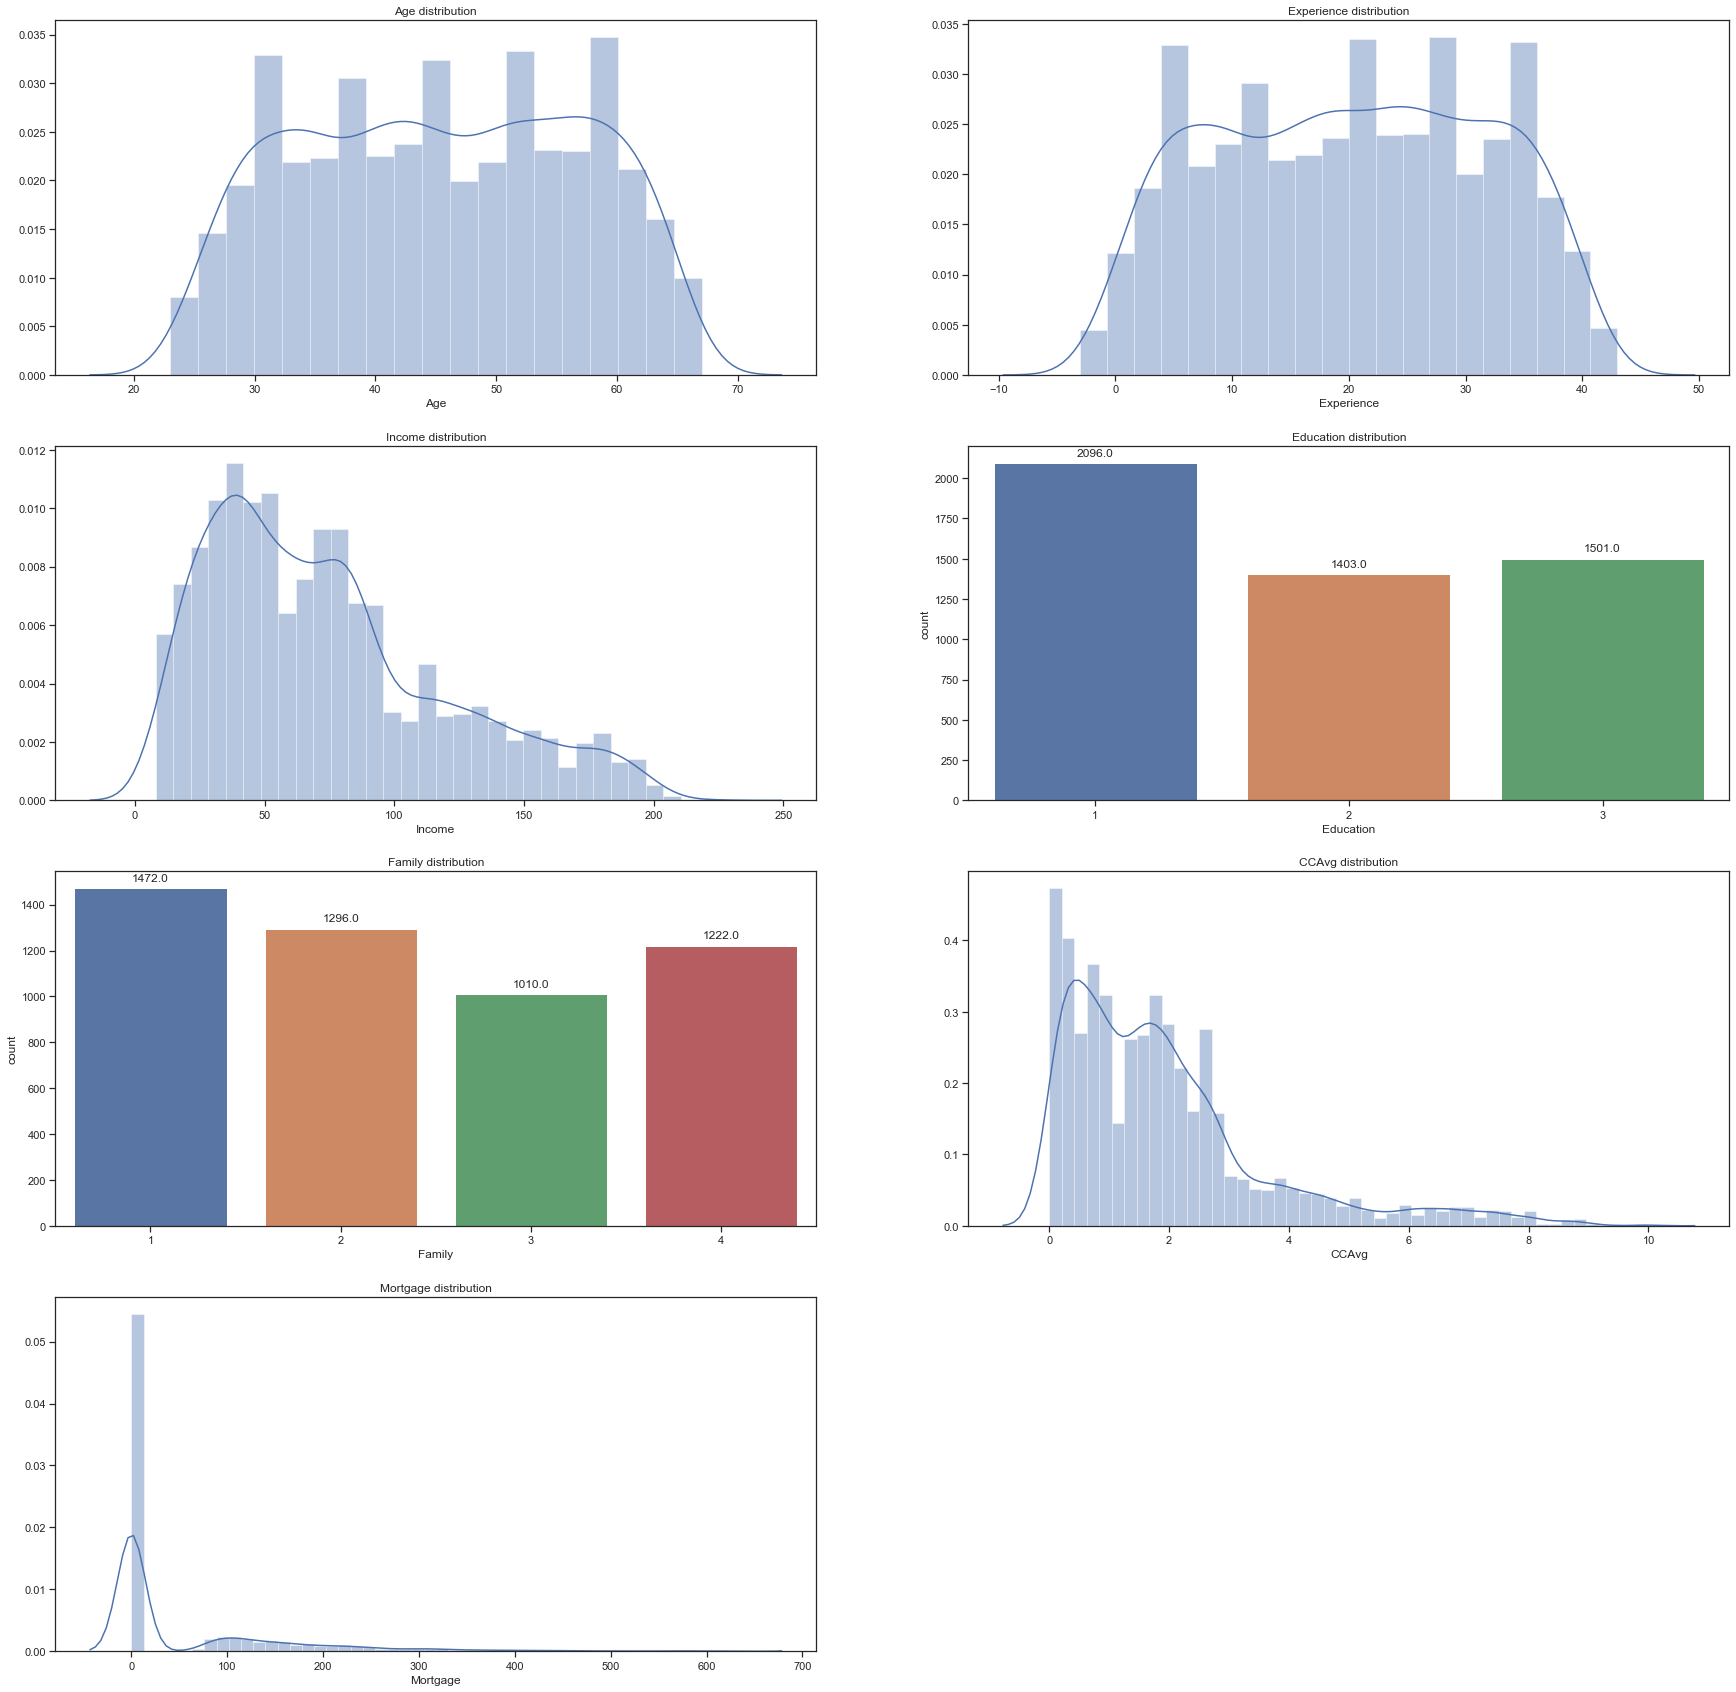

In [5]:
fig = plt.figure(figsize=(30, 30))
gs = fig.add_gridspec(4, 2)

fig_ax1 = fig.add_subplot(gs[0, 0])
sns.distplot(personalLoan['Age'], ax=fig_ax1)
fig_ax1.set_title('Age distribution')

fig_ax2 = fig.add_subplot(gs[0, 1])
sns.distplot(personalLoan['Experience'], ax=fig_ax2)
fig_ax2.set_title('Experience distribution')

fig_ax3 = fig.add_subplot(gs[1, 0])
sns.distplot(personalLoan['Income'], ax=fig_ax3)
fig_ax3.set_title('Income distribution')

fig_ax4 = fig.add_subplot(gs[1, 1])
p1=sns.countplot(personalLoan['Education'], ax=fig_ax4)
for p in p1.patches:
    p1.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig_ax4.set_title('Education distribution')

fig_ax5 = fig.add_subplot(gs[2, 0])
p1=sns.countplot(personalLoan['Family'], ax=fig_ax5)
for p in p1.patches:
    p1.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig_ax5.set_title('Family distribution')

fig_ax6 = fig.add_subplot(gs[2, 1])
p1=sns.distplot(personalLoan['CCAvg'], ax=fig_ax6)
fig_ax6.set_title('CCAvg distribution')

fig_ax7 = fig.add_subplot(gs[3, 0])
p1=sns.distplot(personalLoan['Mortgage'], ax=fig_ax7)
fig_ax7.set_title('Mortgage distribution')

Other attributes are either 0 or 1. Almost all column data is not varying much in the distribution in terms of scale however Income and CCAvg have a right skew in the distribution. Mortgage value has a bimodal distribution

### Removing relevant columns
Let us remove certain columns such as Zip Code for checking values to see outliers or potential wrong values. Also Education column will need to be encoded

In [6]:
personalLoanDf = pd.get_dummies(personalLoan, prefix='Education', columns=['Education'])
personalLoanDf.drop(['ZIP Code'] ,axis=1, inplace=True)
personalLoanDf.rename(columns={'Education_1':'Undergrad', 'Education_2':'Graduate', 'Education_3':'Advanced/Professional'}, inplace=True)
personalLoanDf.head()

,ID,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Undergrad,Graduate,Advanced/Professional
0,1,25,1,49,4,1.6,0,0,1,0,0,0,1,0,0
1,2,45,19,34,3,1.5,0,0,1,0,0,0,1,0,0
2,3,39,15,11,1,1.0,0,0,0,0,0,0,1,0,0
3,4,35,9,100,1,2.7,0,0,0,0,0,0,0,1,0
4,5,35,8,45,4,1.0,0,0,0,0,0,1,0,1,0


Lets print all the unique values of the resulting dataframe to check the pattern. This will help us know potential values that need to be imputed where necessary

In [7]:
# Print each column values for unique ness
for column in personalLoanDf.columns:
    print('---- ', column, ' ----')
    print(personalLoanDf[column].unique())

----  ID  ----
[   1    2    3 ... 4998 4999 5000]
----  Age  ----
[25 45 39 35 37 53 50 34 65 29 48 59 67 60 38 42 46 55 56 57 44 36 43 40
 30 31 51 32 61 41 28 49 47 62 58 54 33 27 66 24 52 26 64 63 23]
----  Experience  ----
[ 1 19 15  9  8 13 27 24 10 39  5 23 32 41 30 14 18 21 28 31 11 16 20 35
  6 25  7 12 26 37 17  2 36 29  3 22 -1 34  0 38 40 33  4 -2 42 -3 43]
----  Income  ----
[ 49  34  11 100  45  29  72  22  81 180 105 114  40 112 130 193  21  25
  63  62  43 152  83 158  48 119  35  41  18  50 121  71 141  80  84  60
 132 104  52 194   8 131 190  44 139  93 188  39 125  32  20 115  69  85
 135  12 133  19  82 109  42  78  51 113 118  64 161  94  15  74  30  38
   9  92  61  73  70 149  98 128  31  58  54 124 163  24  79 134  23  13
 138 171 168  65  10 148 159 169 144 165  59  68  91 172  55 155  53  89
  28  75 170 120  99 111  33 129 122 150 195 110 101 191 140 153 173 174
  90 179 145 200 183 182  88 160 205 164  14 175 103 108 185 204 154 102
 192 202 162 142  95 184 

From the above output, we observe that the **'Experience'** column has certain values that need imputation. Values such as -1, -2, -3 are likely wrong values and can either be removed or replaced by the **'Mean'**. Remaining columns dont have any wrong data and can be used as such.

In [8]:
# Use describe to investigate the column values.
personalLoanDf.describe()

,ID,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Undergrad,Graduate,Advanced/Professional
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,2.396400,1.937938,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000,0.419200,0.280600,0.300200
std,1443.520003,11.463166,11.467954,46.033729,1.147663,1.747659,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637,0.493478,0.449337,0.458391
min,1.000000,23.000000,-3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,1.000000,0.700000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,2.000000,1.500000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,3.000000,2.500000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,4.000000,10.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


Experience is an important feature that comes with Age and can also play a good role in enhancing the predictability of the target variable because experience shows maturity in the individual and ability to take decisions.

In [9]:
# Check how many rows contain -1, -2, -3 in 'Experience'
personalLoanDf['Experience'].value_counts()

 32    154
 20    148
 9     147
 5     146
 23    144
 35    143
 25    142
 28    138
 18    137
 19    135
 26    134
 24    131
 3     129
 14    127
 16    127
 30    126
 34    125
 27    125
 17    125
 29    124
 22    124
 7     121
 8     119
 6     119
 15    119
 10    118
 33    117
 13    117
 11    116
 37    116
 36    114
 21    113
 4     113
 31    104
 12    102
 38     88
 39     85
 2      85
 1      74
 0      66
 40     57
 41     43
-1      33
-2      15
 42      8
-3       4
 43      3
Name: Experience, dtype: int64

A look at the above output reveals that there are 52 rows containing negative values in **Experience**. Imputing this to the **Mean**

In [10]:
imputer = Pipeline(steps=[
            ('imputer_1', SimpleImputer(strategy='constant', missing_values=-1, fill_value=20)),
            ('imputer_2', SimpleImputer(strategy='constant', missing_values=-2, fill_value=20)),
            ('imputer_3', SimpleImputer(strategy='constant', missing_values=-3, fill_value=20))
        ])

preprocessor = ColumnTransformer(transformers=[('imputerExperience', imputer, ['Experience'])])
preprocessor.fit(personalLoanDf)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('imputerExperience',
                                 Pipeline(memory=None,
                                          steps=[('imputer_1',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=20,
                                                                missing_values=-1,
                                                                strategy='constant',
                                                                verbose=0)),
                                                 ('imputer_2',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
      

In [11]:
personalLoanDf.insert(3, 'Imp_Experience', preprocessor.transform(personalLoanDf))

personalLoanDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
ID                       5000 non-null int64
Age                      5000 non-null int64
Experience               5000 non-null int64
Imp_Experience           5000 non-null int64
Income                   5000 non-null int64
Family                   5000 non-null int64
CCAvg                    5000 non-null float64
Mortgage                 5000 non-null int64
Personal Loan            5000 non-null int64
Securities Account       5000 non-null int64
CD Account               5000 non-null int64
Online                   5000 non-null int64
CreditCard               5000 non-null int64
Undergrad                5000 non-null uint8
Graduate                 5000 non-null uint8
Advanced/Professional    5000 non-null uint8
dtypes: float64(1), int64(12), uint8(3)
memory usage: 522.6 KB


In [12]:
# scaling the mortgage attribute using a log transformation due to the large variation in the values
transformer = FunctionTransformer(np.log1p)
personalLoanDf.insert(8, 'log_Mortgage', transformer.transform(personalLoanDf[['Mortgage']]))
personalLoanDf.head()

,ID,Age,Experience,Imp_Experience,Income,Family,CCAvg,Mortgage,log_Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Undergrad,Graduate,Advanced/Professional
0,1,25,1,1,49,4,1.6,0,0.0,0,1,0,0,0,1,0,0
1,2,45,19,19,34,3,1.5,0,0.0,0,1,0,0,0,1,0,0
2,3,39,15,15,11,1,1.0,0,0.0,0,0,0,0,0,1,0,0
3,4,35,9,9,100,1,2.7,0,0.0,0,0,0,0,0,0,1,0
4,5,35,8,8,45,4,1.0,0,0.0,0,0,0,0,1,0,1,0


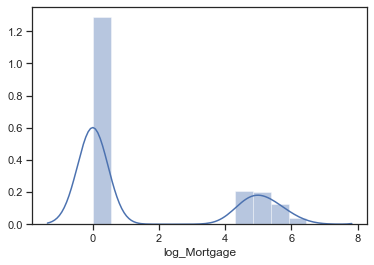

In [13]:
sns.distplot(personalLoanDf['log_Mortgage'])

### Printing the variables to evaluate the 5 point summary

In [14]:
personalLoanDf.describe()

,ID,Age,Experience,Imp_Experience,Income,Family,CCAvg,Mortgage,log_Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Undergrad,Graduate,Advanced/Professional
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,20.327600,73.774200,2.396400,1.937938,56.498800,1.566982,0.096000,0.104400,0.06040,0.596800,0.294000,0.419200,0.280600,0.300200
std,1443.520003,11.463166,11.467954,11.253035,46.033729,1.147663,1.747659,101.713802,2.366428,0.294621,0.305809,0.23825,0.490589,0.455637,0.493478,0.449337,0.458391
min,1.000000,23.000000,-3.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,11.000000,39.000000,1.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,20.000000,64.000000,2.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3750.250000,55.000000,30.000000,30.000000,98.000000,3.000000,2.500000,101.000000,4.624973,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,43.000000,224.000000,4.000000,10.000000,635.000000,6.455199,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


### Plotting the variables by how many took personal loan and how many didn't

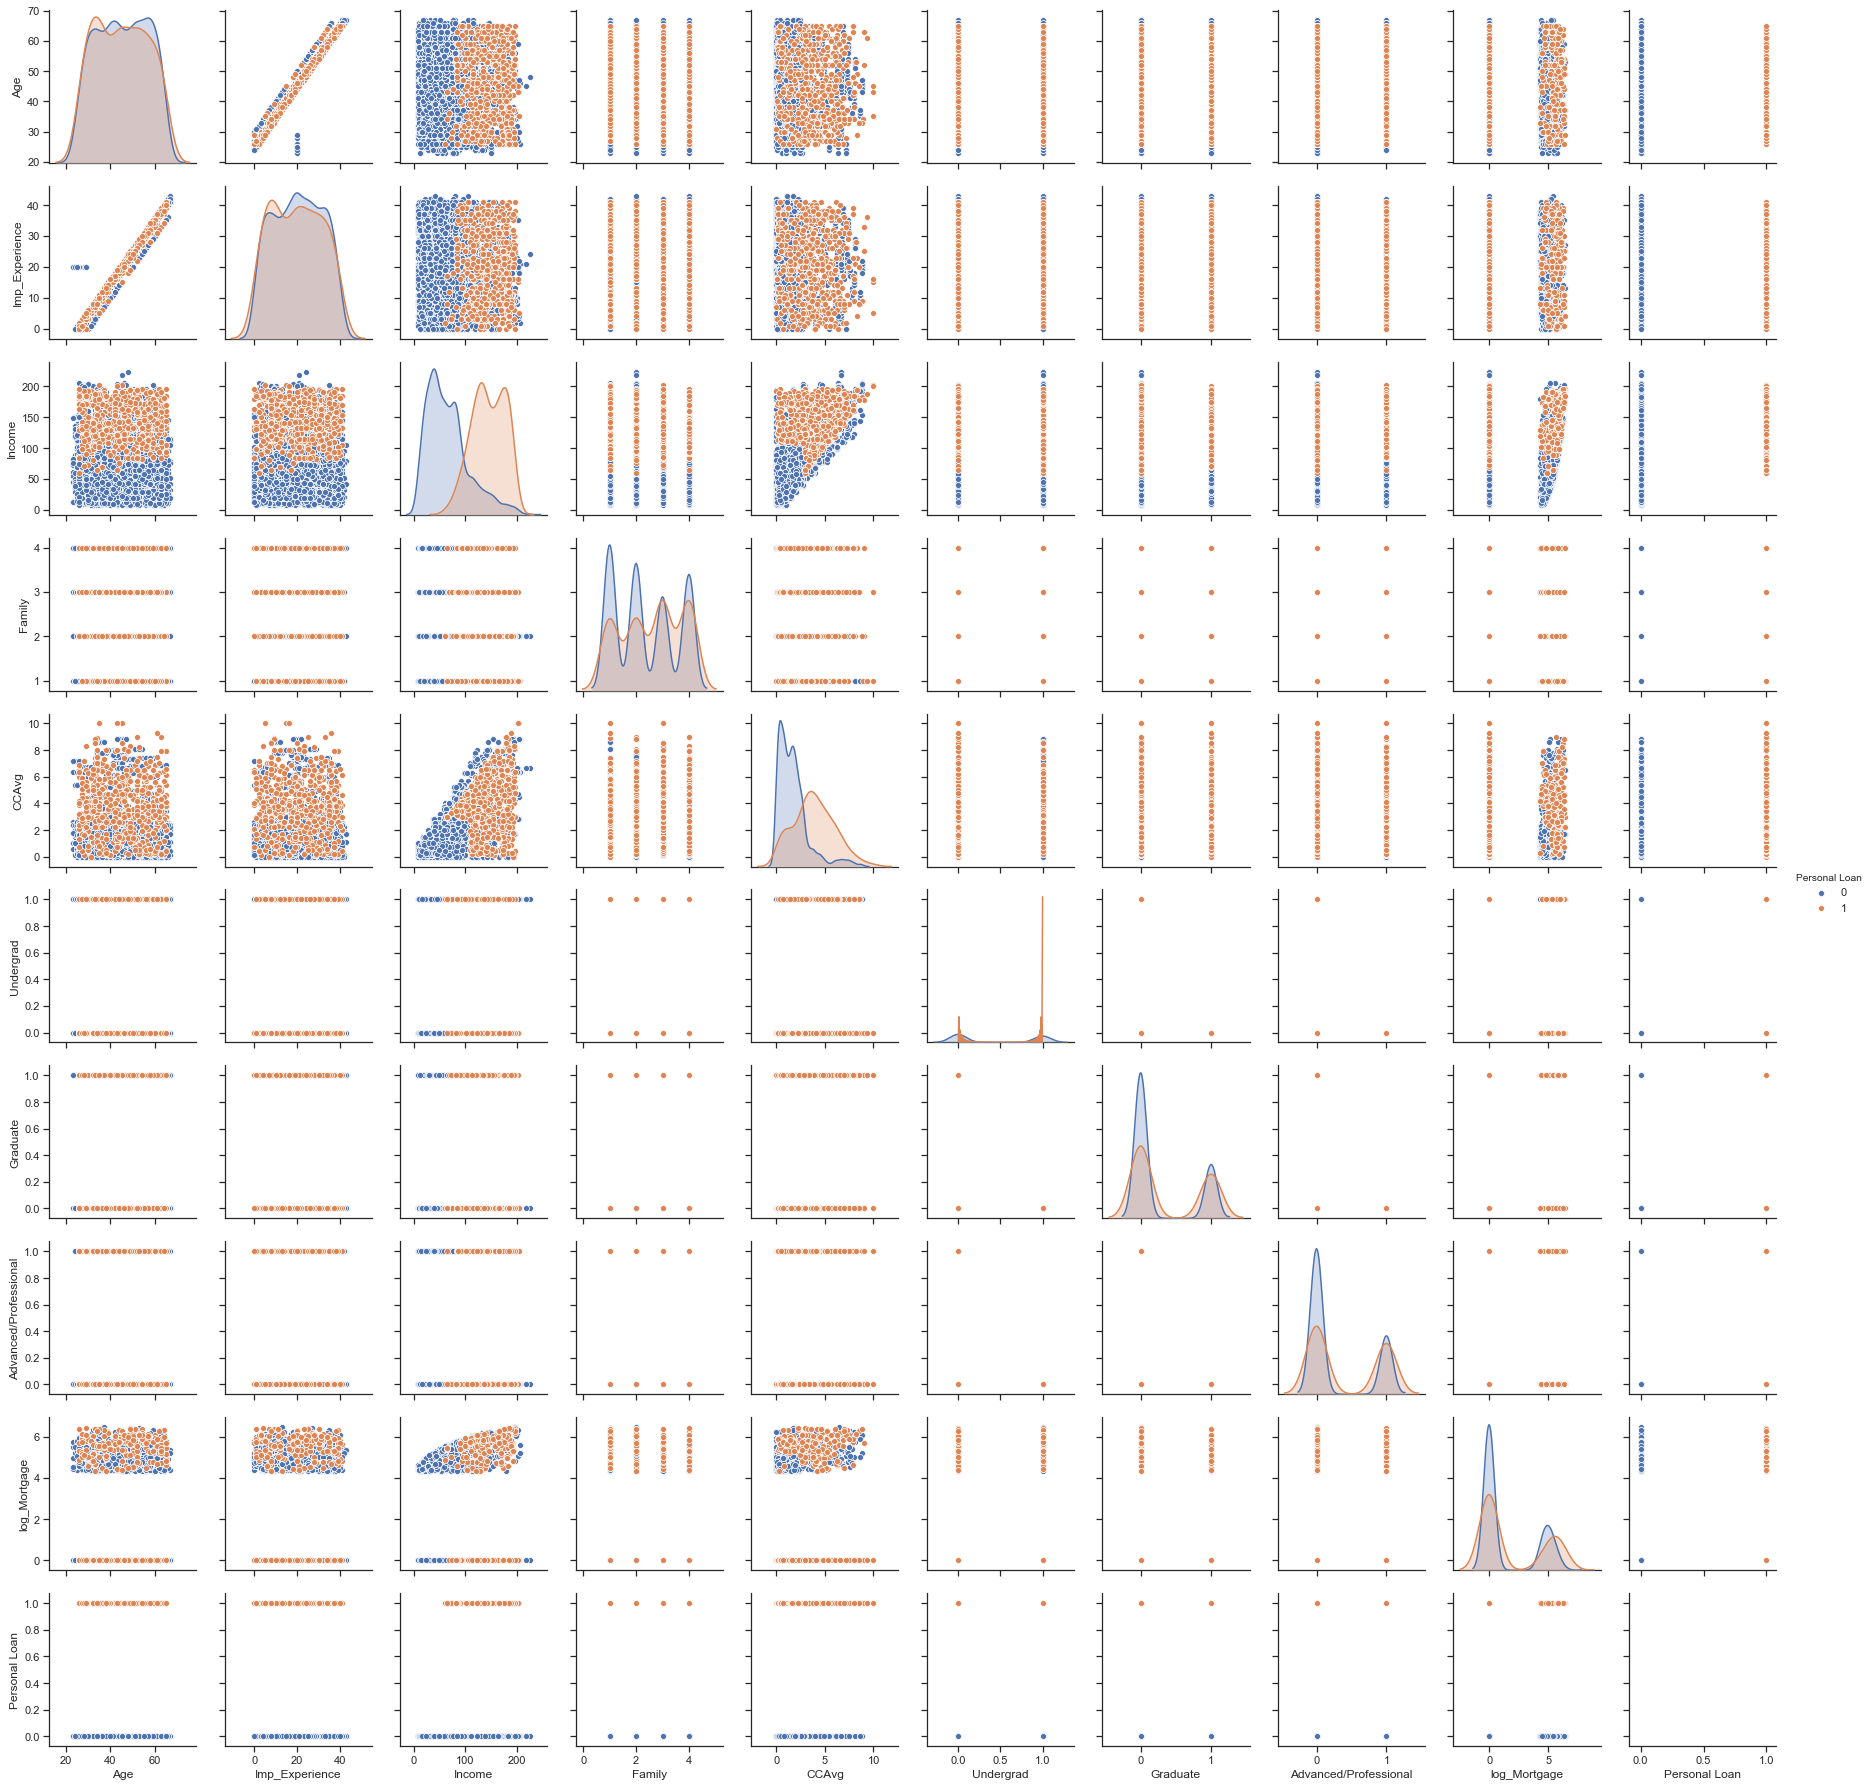

In [15]:
sns.pairplot(personalLoanDf[['Age', 'Imp_Experience', 'Income', 'Family', 'CCAvg', 'Undergrad', 'Graduate', 'Advanced/Professional', 'log_Mortgage', 'Personal Loan']], hue="Personal Loan")

* The age attribute has a fairly uniform distribution and for the target variable
* Experience attribute also has a fairly uniform representation with the target variable
* Higher income people tend to take loans more than lower income people
* People with higher average card spends have accepted personal loans
* No of family members doesnot impact the personal loan acceptance drastically as it is found to be almost same for 1,2,3,4 members across the population

## Analysis of the features



### Get the target column distribution

Counter({0: 4520, 1: 480})


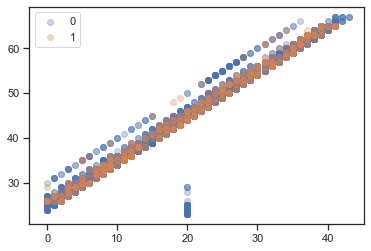

In [16]:
# the x variables are picked up from the dataframe. 
# Education_3 is ignored because presence or absence of Education_1 and/or Education_2 already 
# explains the presence or absence of Education_3
# Personal Loan is the target variable and imputed Experience column is used instead of the old column
dropped_features = ['ID', 'Experience', 'Advanced/Professional', 'Mortgage', 'Personal Loan']
X = personalLoanDf.drop(dropped_features ,axis=1)

# Extracting the y or the target variable
y = personalLoanDf['Personal Loan']

counter = Counter(y)
print(counter)

# scatter plot of examples by class variable
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X.iloc[row_ix, 1], X.iloc[row_ix, 0], label=str(label), alpha=0.3)
plt.legend()
plt.show()

A plot of the target variable by class shown above summarizes the distribution. We can see that the dataset has an 4520:480 class distribution with 4520 examples in the majority class and 480 in the minority class.

The Scatter plot of this dataset shows a large mass of examples for the majority class(blue) and a small number of examples for the minority class(orange)

## Split the data into training and test set in the ratio of 70:30

In [17]:
# Splitting the data by 70:30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# verify the data is randomized by looking at the ID field.
X_train.head()

,Age,Imp_Experience,Income,Family,CCAvg,log_Mortgage,Securities Account,CD Account,Online,CreditCard,Undergrad,Graduate
1334,47,22,35,2,1.3,0.000000,0,0,1,0,1,0
4768,38,14,39,1,2.0,0.000000,0,0,1,0,0,1
65,59,35,131,1,3.8,0.000000,0,0,1,1,1,0
177,29,3,65,4,1.8,5.501258,0,0,0,0,0,1
4489,39,13,21,3,0.2,0.000000,0,0,1,0,0,1


In [18]:
# Check if the split is 70:30
print("{0:0.2f}% data is in training set".format((len(X_train)/len(personalLoanDf.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(personalLoanDf.index)) * 100))

70.00% data is in training set
30.00% data is in test set


Verify the original and training/test set to see if there is equal represention of the target values with the same proportion

In [19]:
print("Original Personal Loan True Values    : {0} ({1:0.2f}%)".format(len(personalLoanDf.loc[personalLoanDf['Personal Loan'] == 1]), (len(personalLoanDf.loc[personalLoanDf['Personal Loan'] == 1])/len(personalLoanDf.index)) * 100))
print("Original Personal Loan False Values   : {0} ({1:0.2f}%)".format(len(personalLoanDf.loc[personalLoanDf['Personal Loan'] == 0]), (len(personalLoanDf.loc[personalLoanDf['Personal Loan'] == 0])/len(personalLoanDf.index)) * 100))
print("")
print("Training Personal Loan True Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Personal Loan False Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Personal Loan True Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Personal Loan False Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))
print("")

Original Personal Loan True Values    : 480 (9.60%)
Original Personal Loan False Values   : 4520 (90.40%)

Training Personal Loan True Values    : 331 (9.46%)
Training Personal Loan False Values   : 3169 (90.54%)

Test Personal Loan True Values        : 149 (9.93%)
Test Personal Loan False Values       : 1351 (90.07%)



## Predict the likelihood of a customer buying personal loans

liblinear 0.9542857142857143
newton-cg 0.9562857142857143
lbfgs 0.9522857142857143
sag 0.9088571428571428
saga 0.9022857142857142


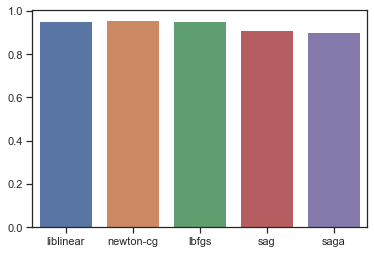

In [20]:
# Define the various solvers
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
parameters = dict(solver=solver_list)

model = LogisticRegression(C=1, random_state=34)
clf = GridSearchCV(model, parameters, cv=2)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']
for score, solver in zip(scores, solver_list):
    print(solver, score)
sns.barplot(solver_list, scores)

The accuracy of the sag and saga solvers are a bit lower than their peers. liblinear, newton-cg and lbfgs all give fairly equal scores. However newton-cg is chosen as the best estimator. C value can be tweaked. Smaller values have more regularization. However default of 1 is found to give the best results in this case

### Predicting using the best estimator

In [21]:
#predict on test
y_predict = clf.predict(X_test)

#coef_df = pd.DataFrame(clf.coef_)
#coef_df['intercept'] = clf.intercept_
print('Accuracy of the model is : {:.9f}'.format(clf.score(X_test, y_test)))

Accuracy of the model is : 0.958000000


ROC Curve Plots and Characteristics
------------------------------------------------------


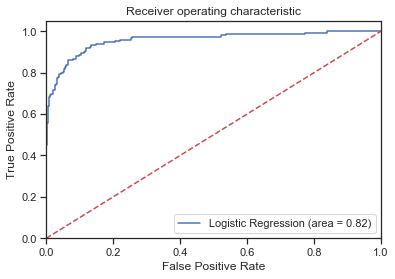

In [22]:
print('ROC Curve Plots and Characteristics')
print('------------------------------------------------------')
logreg_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logreg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## The confusion matrix

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    #plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; miss-classification={:0.4f}'.format(accuracy, misclass))

Model Score Summary
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1351
           1       0.91      0.64      0.75       149

    accuracy                           0.96      1500
   macro avg       0.93      0.82      0.86      1500
weighted avg       0.96      0.96      0.95      1500



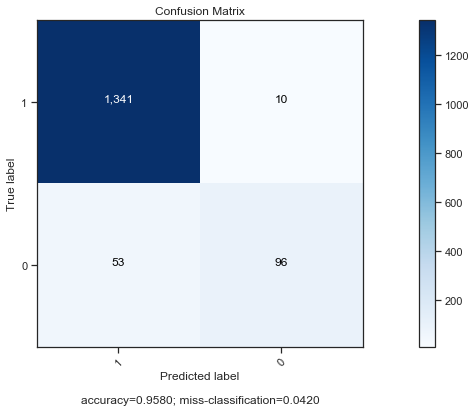

In [24]:
print('Model Score Summary')
print('------------------------------------------------------')
print(classification_report(y_test, y_predict))

fig, ax = plt.subplots(figsize=(20, 6))
plot_confusion_matrix(cm           = metrics.confusion_matrix(y_test, y_predict), 
                      normalize    = False,
                      target_names = ['1', '0'],
                      title        = "Confusion Matrix")
plt.show()

The accuracy is 0.958 with a high precision and recall and a f1 score of 0.98 for no loan and 0.75 for predicting a loan conversion

## Reasoning on how can the model perform better

Logistic regression model doesnot support imbalanced classification directly. The training algorithm used to fit the logistic regression model can be modified to take the skewed distribution into account.
* This can be achieved by specifying a class weighting configuration that is used to influence the amount that logistic regression coefficients are updated during training
* The weighing can penalize the model less for errors made on examples from the majority class and penalize the model more for errors made on examples from the minority class
* The result is a version of the logistic regression that performs better on imbalanced classification tasks.

In the above case the class variation is found to be **4520 : 480** from section **1.4.1** above

### Computing required weights

In [25]:
weighting = compute_class_weight('balanced', [0, 1], y)
print(weighting)

[0.55309735 5.20833333]


The above shows that we can achieve a weighting of about 0.552 for class 0 and 5.287 for class 1

### Repeated Cross Validation

We can use repeated cross-validation to evaluate the model with **three repeats** of **10-fold cross-validation**. Model performance will be reported using a mean ROC area under the curve (ROC AUC) averaged over repeats and all folds

In [26]:
# define weights for the classes and use the values from the computed class weights
weights = {1: 0.55309735, 0: 5.20833333}
# define the model with the current best estimator chosen in the previous training
model_new = LogisticRegression(C=1, solver='newton-cg', class_weight=weights, random_state=34)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=34)
#evaluate model
scores_cv = cross_val_score(model_new, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores_cv))

Mean ROC AUC: 0.956


The mean area over multiple folds is now increased to **0.95** from **0.82**. This means there is potential for improvement.

In [27]:
model_new.fit(X_train, y_train)
y_predict_new = model_new.predict(X_test)

### Comparing Confusion Matrices

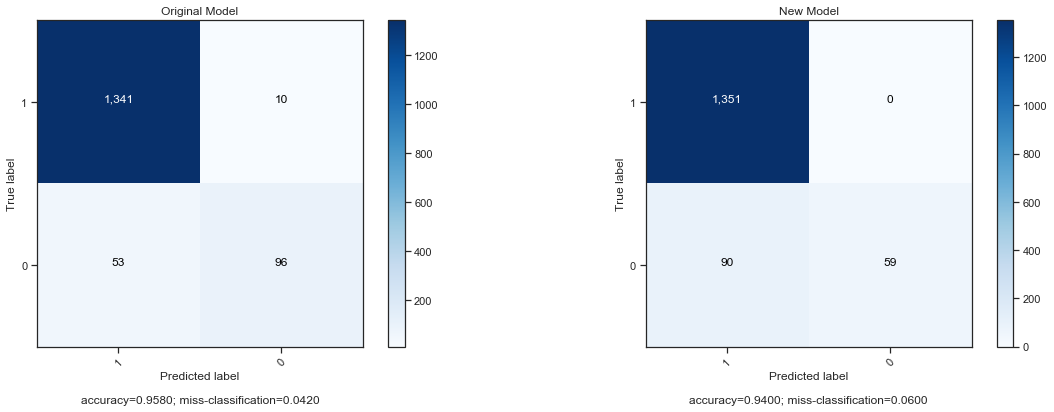

Original Model Score Summary
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1351
           1       0.91      0.64      0.75       149

    accuracy                           0.96      1500
   macro avg       0.93      0.82      0.86      1500
weighted avg       0.96      0.96      0.95      1500

New Model Score Summary
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1351
           1       1.00      0.40      0.57       149

    accuracy                           0.94      1500
   macro avg       0.97      0.70      0.77      1500
weighted avg       0.94      0.94      0.93      1500



In [28]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(1, 2)

fig_ax1 = fig.add_subplot(gs[0, 0])
plot_confusion_matrix(cm           = metrics.confusion_matrix(y_test, y_predict), 
                      normalize    = False,
                      target_names = ['1', '0'],
                      title        = "Confusion Matrix")
fig_ax1.set_title('Original Model')

fig_ax2 = fig.add_subplot(gs[0, 1])
plot_confusion_matrix(cm           = metrics.confusion_matrix(y_test, y_predict_new), 
                      normalize    = False,
                      target_names = ['1', '0'],
                      title        = "Confusion Matrix")
fig_ax2.set_title('New Model')
plt.show()

print('Original Model Score Summary')
print('------------------------------------------------------')
print(classification_report(y_test, y_predict))

print('New Model Score Summary')
print('------------------------------------------------------')
print(classification_report(y_test, y_predict_new))

* The model **Accuracy** is not compromised and fairly same.
* The **F1-score** is not compromised and is fairly same.
* The **True Positives** are higher now.
* The **Precision** for **Class 1** i.e. **Accepting the Personal Loan** is higher now when compared to the previous Confusion Matrix
* **Type II errors** are **0** in the improved model.
* **Type I errors** have slightly increased, but it is ok, since the model predicted that the person will take a loan when actually he didn't.
* Reduction in **True Negatives** is not significant because we are more interested in increasing the predictability of a person taking a loan and not otherwise.
* With slight reduction in **Recall** of **Class 1** we managed to increase the **Recall** of **Class 0**